Together with the marketing department at a big online store, we've compiled a list of hypotheses that may help boost revenue.

**Purpose of the analysis:** prioritize hypotheses, launch an A/B test, and analyze the results.

**Description of the data**

*The hypotheses table:*
- Hypotheses — brief descriptions of the hypotheses
- Reach — user reach, on a scale of one to ten
- Impact — impact on users, on a scale of one to ten
- Confidence — confidence in the hypothesis, on a scale of one to ten
- Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

*The orders table:*
- transactionId — order identifier
- visitorId — identifier of the user who placed the order
- date — of the order
- revenue — from the order
- group — the A/B test group that the user belongs to

*The visits table:*
- date — date
- group — A/B test group
- visits — the number of visits on the date specified in the A/B test group specified

## Preprocess the data

Download the data and prepare it for analysis​.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install sidetable

In [3]:
import sidetable as stb

Let's download **the hypotheses table**.

In [4]:
try:
    hypotheses=pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
except:
    hypotheses = pd.read_csv('C:\\Users\\eduda\\Downloads\\making ab\\hypotheses_us.csv', sep=';')
pd.options.display.max_colwidth = 150
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


We have 9 hypotheses for prioritizing.

Let's check **the orders table**.

In [5]:
try:
    orders=pd.read_csv('/datasets/orders_us.csv')
except:
    orders=pd.read_csv('C:\\Users\\eduda\\Downloads\\making ab\\orders_us.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


Let's change data type in 'data' column to datetime and continue checking the table.

In [7]:
orders['date']= orders['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
orders['date'].dtype

dtype('<M8[ns]')

In [8]:
print('The amount of missing values in the orders table.')
orders.stb.missing(style=True)

The amount of missing values in the orders table.


,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


In [9]:
print('The amount of duplicates in the orders table.')
orders.duplicated().sum()

The amount of duplicates in the orders table.


0

In [10]:
print('The distribution of the orders table.')
orders.describe()

The distribution of the orders table.


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


We don't have missing values, duplucates and zero-values. But the max revenue looks too high, may be it abnormal values.

Let's check that the visitors are correctly divided into groups - none of the visitors got into either group A or group B. Make queries by groups and compare the visitor IDs.

In [11]:
ordersA=orders.query('group == "A"')
len(ordersA)

557

In [12]:
ordersB=orders.query('group == "B"')
len(ordersB)

640

In [13]:
1-len(ordersA)/len(ordersB)

0.12968749999999996

Groups are not equal - group B bigger then A on 13%.

In [14]:
doubledOrders=ordersB[ordersB['visitorId'].isin(ordersA['visitorId'].unique())].reset_index(drop=True)
doubledOrders.shape[0]

92

We have 92 orders from users, which are present in both groups. We will delete them since it is impossible to track which version users viewed when they made purchases.

In [15]:
orders_clean=orders.loc[~orders['visitorId'].isin(doubledOrders['visitorId'].unique())].reset_index(drop=True)
orders_clean

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,3797467345,1196621759,2019-08-15,155.1,B
3,2282983706,2322279887,2019-08-15,40.5,B
4,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1011,3592955527,608641596,2019-08-14,255.7,B
1012,2662137336,3733762160,2019-08-14,100.8,B
1013,2203539145,370388673,2019-08-14,50.1,A
1014,1807773912,573423106,2019-08-14,165.3,A


In [16]:
orders_clean.loc[orders_clean['visitorId'].isin(doubledOrders['visitorId'].unique())]

,transactionId,visitorId,date,revenue,group


In [17]:
orders_clean.describe()

,transactionId,visitorId,revenue
count,1.016000e+03,1.016000e+03,1016.000000
mean,2.155085e+09,2.128677e+09,130.770866
std,1.234372e+09,1.221578e+09,648.079810
min,1.062393e+06,5.114589e+06,5.000000
25%,1.143481e+09,1.043655e+09,20.775000
50%,2.144499e+09,2.150274e+09,50.100000
75%,3.256513e+09,3.146991e+09,126.950000
max,4.288552e+09,4.283872e+09,19920.400000


We still have pretty big max 'revenue' value. May be it's outliers, will check it later.

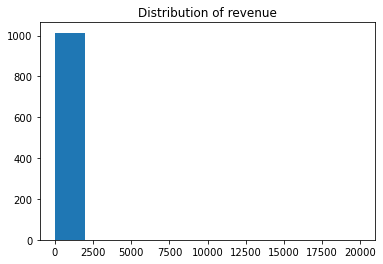

In [18]:
plt.hist(orders_clean['revenue'])
plt.title('Distribution of revenue')
plt.show()

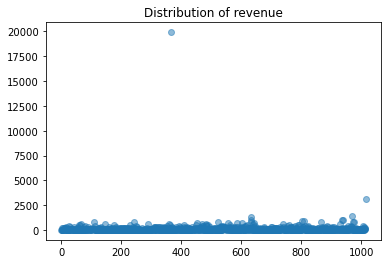

In [19]:
x_values=pd.Series(range(0,len(orders_clean['revenue'])))
plt.title('Distribution of revenue')
plt.scatter(x_values, orders_clean['revenue'], alpha=0.5)
plt.show()

The histogram was not informative, but on the scatter plot we see two abnormal values - around 20000 and 2500. Let's drop them so as not to distort the test results - find them and make a query.

In [20]:
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 39.8+ KB


The final orders table:
- is 1016 rows and 5 columns, all values of the appropriate type,
- doesn't have missing values, duplicales, zero-values,
- doesn't have orders from users which are present in both groups.

**The visits table:**

In [21]:
try:
    visits=pd.read_csv('/datasets/visits_us.csv')
except:
    visits=pd.read_csv('C:\\Users\\eduda\\Downloads\\making ab\\visits_us.csv')
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [22]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Let's change data type in 'data' column to datetime and continue checking the table.

In [23]:
visits['date']= visits['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
visits['date'].dtype

dtype('<M8[ns]')

In [24]:
print('The amount of missing values in the visits table.')
visits.stb.missing(style=True)

The amount of missing values in the visits table.


,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


In [25]:
print('The amount of duplicates in the visits table.')
visits.duplicated().sum()

The amount of duplicates in the visits table.


0

In [26]:
print('The distribution of the visits table.')
visits.describe()

The distribution of the visits table.


,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


The final visits table:
- is 62 rows and 3 columns, all values of the appropriate type,
- doesn't have missing values, duplicales, zero-values.

## Prioritizing Hypotheses

In [27]:
pd.options.display.max_colwidth = 150
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


Let's apply the ICE framework to prioritize hypotheses.

In [28]:
pd.options.display.max_colwidth = 150
hypotheses['ICE']=(hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']
ICE=hypotheses[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False).reset_index(drop=True)
ICE

,Hypothesis,ICE
0,Launch a promotion that gives users discounts on their birthdays,16.200000
1,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
2,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
3,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
5,Launch your own delivery service. This will shorten delivery time,2.000000
6,Add a customer review page. This will increase the number of orders,1.333333
7,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
8,Change the background color on the main page. This will increase user engagement,1.000000


In [29]:
print('ICE gives us the most promising hypotheses:\n-{}\n-{}\n-{}.'.format(*ICE.iloc[:3]['Hypothesis'].values))

ICE gives us the most promising hypotheses:
-Launch a promotion that gives users discounts on their birthdays
-Add two new channels for attracting traffic. This will bring 30% more users
-Add a subscription form to all the main pages. This will help you compile a mailing list.


Let's check the RICE framework to prioritize hypotheses.

In [30]:
pd.options.display.max_colwidth = 150
hypotheses['RICE']=(hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']
RICE=hypotheses[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False).reset_index(drop=True)
RICE

,Hypothesis,RICE
0,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
1,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
2,Add two new channels for attracting traffic. This will bring 30% more users,40.0
3,Show banners with current offers and sales on the main page. This will boost conversion,40.0
4,Launch a promotion that gives users discounts on their birthdays,16.2
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
6,Launch your own delivery service. This will shorten delivery time,4.0
7,Add a customer review page. This will increase the number of orders,4.0
8,Change the background color on the main page. This will increase user engagement,3.0


In [31]:
print('RICE gives us the most promising hypotheses:\n-{}\n-{}\n-{}.'.format(*RICE.iloc[:3]['Hypothesis'].values))

RICE gives us the most promising hypotheses:
-Add a subscription form to all the main pages. This will help you compile a mailing list
-Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
-Add two new channels for attracting traffic. This will bring 30% more users.


**Conclusion**:
- the list of priority hypotheses for ICE and RICE methods includes two identical hypotheses, but in different positions:
    - 'Add a subscription form to all the main pages.' - the first place by RICE and the third place for ICE,
    - 'Add two new channels for attracting traffic.' - the third place by RICE and the second place for ICE.
- 'Launch a promotion that gives users discounts on their birthdays.' - the first place by ICE
- 'Add product recommendation blocks to the store's site.' - the second place for RICE

Those differences can be explained by influence the reach parameter. Therefore, *'Add a subscription form to all the main pages.'* is the most interesting hypothesis for the test - it has the largest audience coverage, it does not require much effort and at the same time has a fairly strong influence on users and has a high confidence paremeter.

## A/B Test Analysis

For test let's divide orders and visits tables by groups and merge them. The orders table we have to group by date before merging.

In [32]:
orders_A=orders_clean[orders_clean['group'] == "A"].groupby('date',as_index=False).agg({'revenue':'sum', 'transactionId':'count'})
orders_A.columns=['date','revenue','orders']
orders_A.shape[0]

31

In [33]:
orders_B=orders_clean[orders_clean['group'] == "B"].groupby('date',as_index=False).agg({'revenue':'sum','transactionId':'count'})
orders_B.columns=['date','revenue','orders']
orders_B.shape[0]

31

In [34]:
visits_A=visits.query('group == "A"').reset_index(drop=True)
len(visits_A)

31

In [35]:
visits_B=visits.query('group == "B"').reset_index(drop=True)
len(visits_B)

31

In [36]:
groupA= pd.merge(orders_A,visits_A[['date','visits']],on='date', how='left')
groupA.head()

,date,revenue,orders,visits
0,2019-08-01,2266.6,23,719
1,2019-08-02,1468.3,19,619
2,2019-08-03,1815.2,24,507
3,2019-08-04,675.5,11,717
4,2019-08-05,1398.0,22,756


In [37]:
groupB= pd.merge(orders_B,visits_B[['date','visits']],on='date', how='left')
groupB.head()

,date,revenue,orders,visits
0,2019-08-01,967.2,17,713
1,2019-08-02,2568.1,23,581
2,2019-08-03,1071.6,14,509
3,2019-08-04,1531.6,14,770
4,2019-08-05,1449.3,21,707


### Graph cumulative revenue by group. 

In [38]:
groupA['cumul_rev']=groupA['revenue'].cumsum()
groupA.head()

,date,revenue,orders,visits,cumul_rev
0,2019-08-01,2266.6,23,719,2266.6
1,2019-08-02,1468.3,19,619,3734.9
2,2019-08-03,1815.2,24,507,5550.1
3,2019-08-04,675.5,11,717,6225.6
4,2019-08-05,1398.0,22,756,7623.6


In [39]:
groupB['cumul_rev']=groupB['revenue'].cumsum()
groupB.head()

,date,revenue,orders,visits,cumul_rev
0,2019-08-01,967.2,17,713,967.2
1,2019-08-02,2568.1,23,581,3535.3
2,2019-08-03,1071.6,14,509,4606.9
3,2019-08-04,1531.6,14,770,6138.5
4,2019-08-05,1449.3,21,707,7587.8


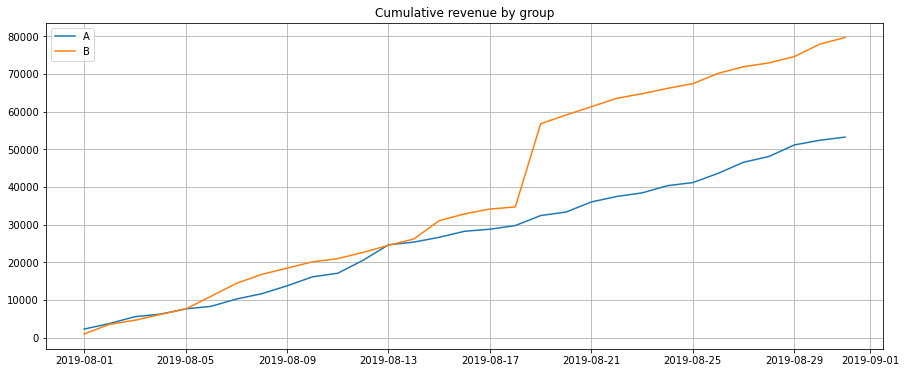

In [40]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(groupA['date'], groupA['cumul_rev'], label='A')
plt.plot(groupB['date'], groupB['cumul_rev'], label='B')
plt.title('Cumulative revenue by group')
plt.grid()
plt.legend()
plt.show()

- cumulative revenue for the B group grows until August 18, when we can observe a jump (probably because of outliers) and stabilized after.
- cumulative revenue for the A group grows until August 13 and then seems stabilized.
- after stabilization group's cumulative revenue goes in parallel.
- we can mention the opposite direction for groups between August 5 and 13.
- we can see several days when cumulative revenue has the same value for both groups - about August 5 and 13. Maybe it's a coincidence, or something has affected user behavior, or a data loading error.

### Graph cumulative average order size by group.

In [41]:
groupA['cumul_purch']=groupA['orders'].cumsum()
groupA['cumul_avch']=groupA['cumul_rev']/groupA['cumul_purch']
groupA.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch
0,2019-08-01,2266.6,23,719,2266.6,23,98.547826
1,2019-08-02,1468.3,19,619,3734.9,42,88.926190
2,2019-08-03,1815.2,24,507,5550.1,66,84.092424
3,2019-08-04,675.5,11,717,6225.6,77,80.851948
4,2019-08-05,1398.0,22,756,7623.6,99,77.006061


In [42]:
groupB['cumul_purch']=groupB['orders'].cumsum()
groupB['cumul_avch']=groupB['cumul_rev']/groupB['cumul_purch']
groupB.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch
0,2019-08-01,967.2,17,713,967.2,17,56.894118
1,2019-08-02,2568.1,23,581,3535.3,40,88.382500
2,2019-08-03,1071.6,14,509,4606.9,54,85.312963
3,2019-08-04,1531.6,14,770,6138.5,68,90.272059
4,2019-08-05,1449.3,21,707,7587.8,89,85.256180


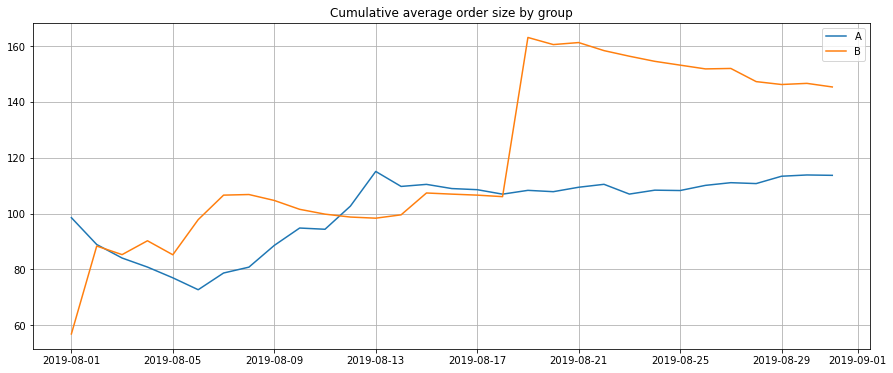

In [43]:
plt.plot(groupA['date'], groupA['cumul_avch'], label='A')
plt.plot(groupB['date'], groupB['cumul_avch'], label='B')
plt.title('Cumulative average order size by group')
plt.grid()
plt.legend()
plt.show()

Let's plot also graph just for revenue.

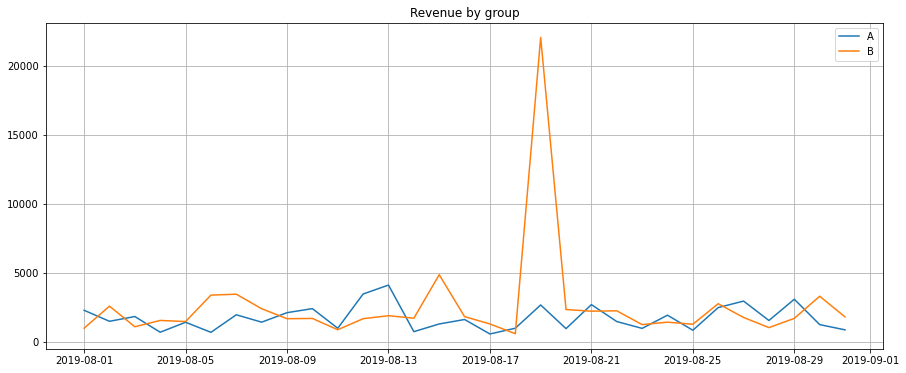

In [44]:
plt.plot(groupA['date'], groupA['revenue'], label='A')
plt.plot(groupB['date'], groupB['revenue'], label='B')
plt.title('Revenue by group')
plt.grid()
plt.legend()
plt.show()

- for cumulative average order we can see the same opposite rise and fall in the beginning of August. 
- after that value for the group A  continues to grow until August 13, after that peak - a smooth decline and stabilization.
- for group B we we can observe the same jump at August 18, a fall and kinda stabilization after.
- we can see fluctuations of overall revenue and opposite directions of  of the chart at the beginning of the test - for example, on August 2 and 6 which shows the impact of changes on user behavior.
- the peak at August 18 for group B on revenue graph confirms the presence of outliers on this day.

### Graph the relative difference in cumulative average order size for group B compared with group A.

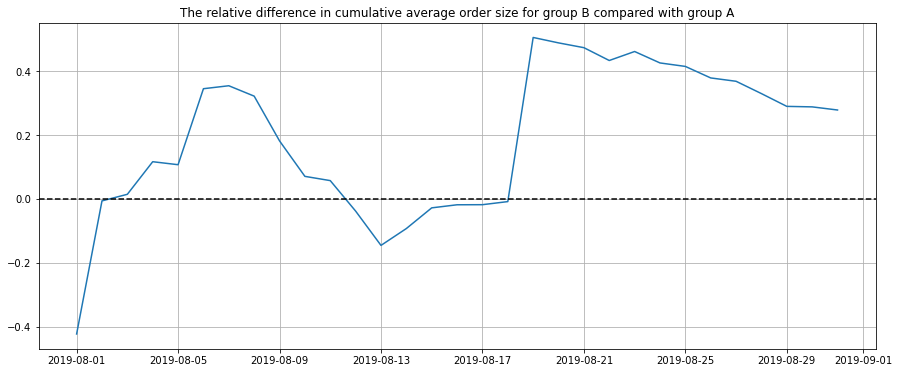

In [45]:
# gathering the data into one DataFrame
merged_data = groupA.merge(groupB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average order sizes
plt.plot(merged_data['date'], (merged_data['cumul_avchB']/merged_data['cumul_avchA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')
plt.title('The relative difference in cumulative average order size for group B compared with group A')
plt.grid()
plt.show()

- the relative difference in cumulative average order size for group B compared with group A demonstrates fluctuations.
- we can observe a rise until August 7, then a fall until August 13, another rise August 18, fall and stabilization.

### Calculate each group's  cumulative conversion rate as the ratio of orders to the number of visits for each day.

In [46]:
groupA['conversion']=groupA['orders']/groupA['visits']
groupA['cum_conv']=groupA['orders'].cumsum()/groupA['visits'].cumsum()
groupA.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch,conversion,cum_conv
0,2019-08-01,2266.6,23,719,2266.6,23,98.547826,0.031989,0.031989
1,2019-08-02,1468.3,19,619,3734.9,42,88.926190,0.030695,0.031390
2,2019-08-03,1815.2,24,507,5550.1,66,84.092424,0.047337,0.035772
3,2019-08-04,675.5,11,717,6225.6,77,80.851948,0.015342,0.030055
4,2019-08-05,1398.0,22,756,7623.6,99,77.006061,0.029101,0.029837


In [47]:
groupB['conversion']=groupB['orders']/groupB['visits']
groupB['cum_conv']=groupB['orders'].cumsum()/groupB['visits'].cumsum()
groupB.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch,conversion,cum_conv
0,2019-08-01,967.2,17,713,967.2,17,56.894118,0.023843,0.023843
1,2019-08-02,2568.1,23,581,3535.3,40,88.382500,0.039587,0.030912
2,2019-08-03,1071.6,14,509,4606.9,54,85.312963,0.027505,0.029950
3,2019-08-04,1531.6,14,770,6138.5,68,90.272059,0.018182,0.026428
4,2019-08-05,1449.3,21,707,7587.8,89,85.256180,0.029703,0.027134


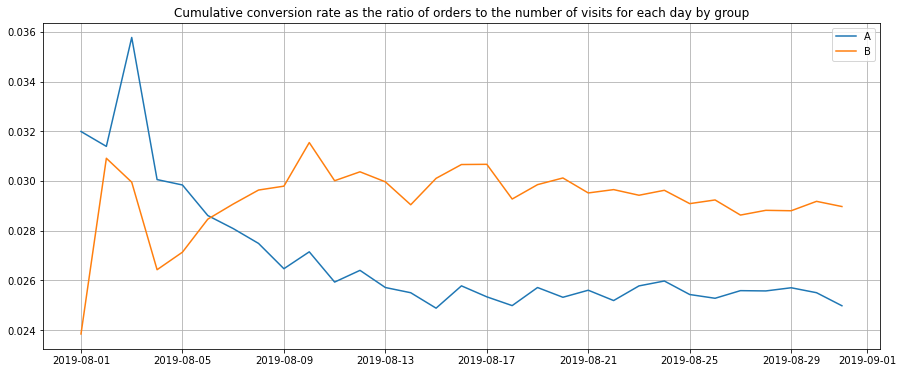

In [48]:
plt.plot(groupA['date'], groupA['cum_conv'], label='A')
plt.plot(groupA['date'], groupB['cum_conv'], label='B')
plt.title('Cumulative conversion rate as the ratio of orders to the number of visits for each day by group')
plt.grid()
plt.legend()
plt.show()

In [49]:
#overall conversion control:
groupA['orders'].sum()/groupA['visits'].sum()

0.02497865072587532

In [50]:
#overall conversion control:
groupB['orders'].sum()/groupB['visits'].sum()

0.02897018397124128

- the group B has a little higher conversion rate.

### Plot a scatter chart of the number of orders per user. 

In [51]:
orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,3797467345,1196621759,2019-08-15,155.1,B
3,2282983706,2322279887,2019-08-15,40.5,B
4,182168103,935554773,2019-08-15,35.0,B


In [52]:
ordersByUsers = (
    orders_clean.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head())

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3


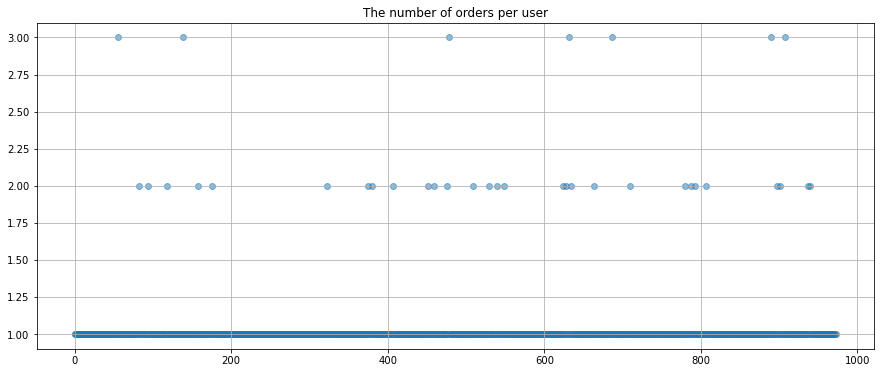

In [53]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5) 
plt.title('The number of orders per user')
plt.grid()
plt.show()

- the majority of customers placed only one order. 
- however, a significant share placed two orders.

### Calculate the 95th and 99th percentiles for the number of orders per user.

In [54]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


- 5% of users made more than one order and only 1% made more than two.
- thus, it would be reasonable to set two orders per user as the lower limit for the number of orders and to filter anomalies on that basis.

### Plot a scatter chart of order prices.

In [55]:
order_price = (
    orders_clean.drop(['group', 'date', 'transactionId'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'revenue': 'mean'})
)
order_price.columns = ['visitorId', 'price']
print(order_price.sort_values(by='price', ascending=False).head())

      visitorId    price
440  1920142716  19920.4
477  2108080724   3120.1
300  1307669133   1425.8
202   888512513   1335.6
938  4133034833   1050.0


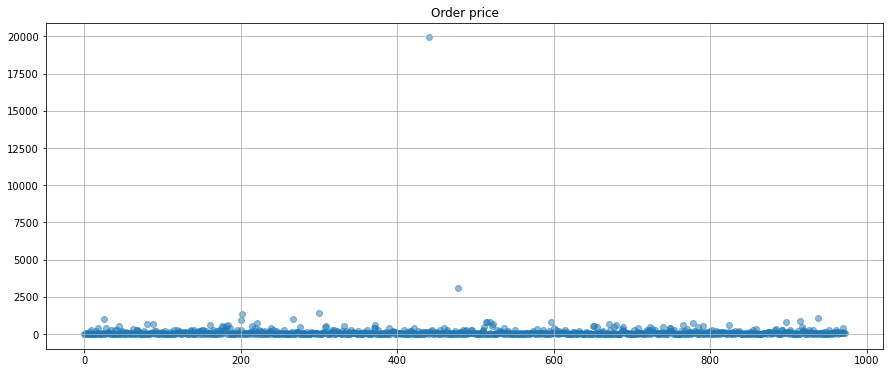

In [56]:
x_values = pd.Series(range(0,len(order_price)))
plt.scatter(x_values, order_price['price'], alpha=0.5) 
plt.title('Order price')
plt.grid()
plt.show()

- almost all order prices are up to 2500.

### Calculate the 95th and 99th percentiles of order prices.

In [57]:
print(np.percentile(order_price['price'], [95, 99])) 

[429.74 830.3 ]


- 5% of users made an order worth more than 430 dollars and only 1% of orders have cost more than 831.
- thus, it would be reasonable to set order price in 831 dollar as the lower limit for the number of orders and to filter anomalies on that basis.

### Filter data.

Let's filter data ased on conclusions in 3.6 and 3.8 steps and calculate all parametrs for future comparison.

In [58]:
abnormal_orders=ordersByUsers.query('orders>2').reset_index(drop=True)
abnormal_orders.shape[0]

7

In [59]:
abnormal_price=order_price.query('price>830').reset_index(drop=True)
abnormal_price.shape[0]

12

In [60]:
abnormal_users=pd.merge(abnormal_price,abnormal_orders,on='visitorId', how='outer')
abnormal_users.shape[0]

19

In [61]:
filtered_orders=orders.loc[~orders['visitorId'].isin(abnormal_users['visitorId'].unique())]
filtered_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [62]:
filtered_orders_A=filtered_orders[filtered_orders['group'] == "A"].groupby('date',as_index=False).agg({'revenue':'sum', 'transactionId':'count'})
filtered_orders_A.columns=['date','revenue','orders']
filtered_orders_A.shape[0]

31

In [63]:
filtered_orders_B=filtered_orders[filtered_orders['group'] == "B"].groupby('date',as_index=False).agg({'revenue':'sum', 'transactionId':'count'})
filtered_orders_B.columns=['date','revenue','orders']
filtered_orders_B.shape[0]

31

In [64]:
filtered_groupA= pd.merge(filtered_orders_A,visits_A[['date','visits']],on='date', how='left')
filtered_groupA['cumul_rev']=filtered_groupA['revenue'].cumsum()
filtered_groupA['cumul_purch']=filtered_groupA['orders'].cumsum()
filtered_groupA['cumul_avch']=filtered_groupA['cumul_rev']/filtered_groupA['cumul_purch']
filtered_groupA['conversion']=filtered_groupA['orders']/filtered_groupA['visits']
filtered_groupA.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch,conversion
0,2019-08-01,1869.5,19,719,1869.5,19,98.394737,0.026426
1,2019-08-02,1473.5,19,619,3343.0,38,87.973684,0.030695
2,2019-08-03,1815.2,24,507,5158.2,62,83.196774,0.047337
3,2019-08-04,1146.6,16,717,6304.8,78,80.830769,0.022315
4,2019-08-05,1988.1,25,756,8292.9,103,80.513592,0.033069


In [65]:
filtered_groupB= pd.merge(filtered_orders_B,visits_B[['date','visits']],on='date', how='left')
filtered_groupB['cumul_rev']=filtered_groupB['revenue'].cumsum()
filtered_groupB['cumul_purch']=filtered_groupB['orders'].cumsum()
filtered_groupB['cumul_avch']=filtered_groupB['cumul_rev']/filtered_groupB['cumul_purch']
filtered_groupB['conversion']=filtered_groupB['orders']/filtered_groupB['visits']
filtered_groupB.head()

,date,revenue,orders,visits,cumul_rev,cumul_purch,cumul_avch,conversion
0,2019-08-01,1620.0,21,713,1620.0,21,77.142857,0.029453
1,2019-08-02,2623.8,24,581,4243.8,45,94.306667,0.041308
2,2019-08-03,1806.8,16,509,6050.6,61,99.190164,0.031434
3,2019-08-04,1717.3,17,770,7767.9,78,99.588462,0.022078
4,2019-08-05,1495.0,23,707,9262.9,101,91.711881,0.032532


### Find the statistical significance of the difference in conversion between the groups using the raw data.

Let's calculate trials and successes for both groups and write a function to find the statistical significance of the difference in conversion between the groups.

In [66]:
groupA_trials=groupA['visits'].sum()
print("Trials:",groupA_trials)
groupA_successes=groupA['orders'].sum()
print("Successes:",groupA_successes)

Trials: 18736
Successes: 468


In [67]:
groupB_trials=groupB['visits'].sum()
print("Trials:",groupB_trials)
groupB_successes=groupB['orders'].sum()
print("Successes:",groupB_successes)

Trials: 18916
Successes: 548


In [68]:
def check_hypothesis(successes1,trials1, successes2,trials2, alpha=0.05):
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
  
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    
    if (p_value<alpha):
        print('Rejecting the null hypothesis: there is the statistical significance of the difference in conversion between the groups.')
    else:
        print('Failed to reject the null hypothesis: there is no reason to consider the statistical significance of the difference in conversion between the groups.')

In [69]:
check_hypothesis(groupA_successes,groupA_trials, groupB_successes,groupB_trials, alpha=0.05)

p-value:  0.016851380434703023
Rejecting the null hypothesis: there is the statistical significance of the difference in conversion between the groups.


### Find the statistical significance of the difference in average order size between the groups using the raw data.

In [70]:
groupA['avg_order']=groupA['revenue']/groupA['orders']
groupB['avg_order']=groupB['revenue']/groupB['orders']

In [71]:
groupA['avg_order'].mean()

115.51247176082741

In [72]:
groupB['avg_order'].mean()

138.37116968351648

In [73]:
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if (p_value<alpha):
        print('Rejecting the null hypothesis: there is the statistical significance of the difference in average order size between the groups.')
    else:
        print('Failed to reject the null hypothesis: there is no reason to consider the statistical significance of the difference in average order size between the groups.')

In [74]:
testing_average(groupA['avg_order'],groupB['avg_order'],alpha=0.05)

0.9550914317372012
Failed to reject the null hypothesis: there is no reason to consider the statistical significance of the difference in average order size between the groups.


### Find the statistical significance of the difference in conversion between the groups using the filtered data. 

Let's calculate trials and successes for both groups using the filtered data and run the function.

In [75]:
filtered_groupA_trials=filtered_groupA['visits'].sum()
print("Trials:",filtered_groupA_trials)
filtered_groupA_successes=filtered_groupA['orders'].sum()
print("Successes:",filtered_groupA_successes)

Trials: 18736
Successes: 535


In [76]:
filtered_groupB_trials=filtered_groupB['visits'].sum()
print("Trials:",filtered_groupB_trials)
filtered_groupB_successes=filtered_groupB['orders'].sum()
print("Successes:",filtered_groupB_successes)

Trials: 18916
Successes: 629


In [77]:
check_hypothesis(filtered_groupA_successes,filtered_groupA_trials, filtered_groupB_successes,filtered_groupB_trials, alpha=0.05)

p-value:  0.008460030902913251
Rejecting the null hypothesis: there is the statistical significance of the difference in conversion between the groups.


### Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [78]:
filtered_groupA['avg_order']=filtered_groupA['revenue']/filtered_groupA['orders']
filtered_groupB['avg_order']=filtered_groupB['revenue']/filtered_groupB['orders']

In [79]:
filtered_groupA['avg_order'].mean()

103.22559649348956

In [80]:
filtered_groupB['avg_order'].mean()

106.449163769215

In [81]:
testing_average(filtered_groupA['avg_order'],filtered_groupB['avg_order'],alpha=0.05)

0.1765215353801155
Failed to reject the null hypothesis: there is no reason to consider the statistical significance of the difference in average order size between the groups.


### Make a decision based on the test results. 

- despite the fact that the group B has a little higher conversion rate, we can observe that the group B demonstrates worse cumulative average order size than the group A.
- despite the fact that there is the statistical significance of the difference in conversion between the groups, we have no reason to consider the statistical significance of the difference in average order size between the groups.

Stop the test. We can conclude that there is no difference between the groups.